# Benchmark Simulated Data Using SNR cutoff and Holdout Validation

### Imports

In [4]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

## External Libraries
import sys
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from autoencode import AEEnsemble
from datasets import UnsupervisedDataset, SupervisedDataset, BenchmarkDataset
from sklearn.mixture import GaussianMixture
import seaborn as sns
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
sns.set_theme()
sns.set_context("paper")

# General Data Directory ##TODO: Please fill in the appropriate directory
os.chdir("/content/")
data_dir = "./gdrive/MyDrive/pedreira"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Define Datasets and AutoEncoder Ensemble

In [9]:
sup_data = BenchmarkDataset(data_dir)
test_idx = []
for i in range(2, 21):
    test_idx.append(list(sup_data.num_units).index(i))
train_idx = np.arange(len(sup_data))
not_test_mask = np.logical_not(np.isin(train_idx, test_idx))
train_idx = train_idx[not_test_mask]
train_data = torch.utils.data.Subset(sup_data, train_idx)
test_data = torch.utils.data.Subset(sup_data, test_idx)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

ae = AEEnsemble(
    optim=torch.optim.Adam,
    convolutional_encoding=False, 
    batch_size=32, 
    epochs=50, 
    lr=(0.001, 0.001, 0.001),
    device=device, 
    activ=nn.ReLU
)

Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0


Define Functions

In [10]:
def gt_gmm(latent_vecs, test_targets):
    test_acc = []
    test_prec = []
    test_recall = []
    session_weights = []
    remapped_preds = []
    for (i, latent), targets in zip(enumerate(latent_vecs), test_targets):
        session_weights.append(len(targets))
        units = set(targets)
        num_units = len(units)
        gmm = GaussianMixture(n_components=num_units)
        pred = gmm.fit_predict(latent)
        remapped_pred = remap_labels(targets, pred)
        remapped_preds.append(remapped_pred)
        prec = []
        recall = []
        for unit in units:
            TP = np.sum(np.logical_and(remapped_pred==unit, targets==unit))
            FP = np.sum(np.logical_and(remapped_pred==unit, targets!=unit))
            if FP == 0:
                prec.append(1)
            else:
                prec.append(TP / (TP + FP))
            TN = np.sum(np.logical_and(remapped_pred!=unit, targets!=unit))
            FN = np.sum(np.logical_and(remapped_pred!=unit, targets==unit))
            if FN == 0:
                recall.append(1)
            else:
                recall.append(TP / (TP + FN))

        test_prec.append(np.mean(prec))
        test_recall.append(np.mean(recall))
        test_acc.append(sum(remapped_pred==targets)/len(targets))

    session_weights = np.array(session_weights) / sum(session_weights)
    avg_acc = np.sum(test_acc*session_weights)
    avg_prec = np.mean(test_acc)
    avg_recall = np.mean(test_recall)
    avg_stats = avg_acc, avg_prec, avg_recall
    session_stats = test_acc, test_prec, test_recall
    return avg_stats, session_stats, remapped_preds

def auto_gmm(latent_vecs, test_targets):
    test_acc = []
    test_prec = []
    test_recall = []
    session_weights = []
    remapped_preds = []
    max_n_comps = 21
    for (i, latent), targets in zip(enumerate(latent_vecs), test_targets):
        session_weights.append(len(targets))
        units = set(targets)
        num_units = len(units)
        bics = []
        preds = []
        for n_comps in range(1, max_n_comps+1):
            gmm = GaussianMixture(n_components=n_comps)
            preds.append(gmm.fit_predict(latent))
            bics.append(gmm.bic(latent))
        pred = preds[np.argmin(bics)]
        print("predicted num_units=", np.argmin(bics)+1)
        print("true num_units=", num_units)
        remapped_pred = remap_labels(targets, pred)
        remapped_preds.append(remapped_pred)
        prec = []
        recall = []
        for unit in units:
            TP = np.sum(np.logical_and(remapped_pred==unit, targets==unit))
            FP = np.sum(np.logical_and(remapped_pred==unit, targets!=unit))
            if FP == 0:
                prec.append(1)
            else:
                prec.append(TP / (TP + FP))
            TN = np.sum(np.logical_and(remapped_pred!=unit, targets!=unit))
            FN = np.sum(np.logical_and(remapped_pred!=unit, targets==unit))
            if FN == 0:
                recall.append(1)
            else:
                recall.append(TP / (TP + FN))

        test_prec.append(np.mean(prec))
        test_recall.append(np.mean(recall))
        test_acc.append(sum(remapped_pred==targets)/len(targets))

    session_weights = np.array(session_weights) / sum(session_weights)
    avg_acc = np.sum(test_acc*session_weights)
    avg_prec = np.mean(test_acc)
    avg_recall = np.mean(test_recall)
    avg_stats = avg_acc, avg_prec, avg_recall
    session_stats = test_acc, test_prec, test_recall
    return avg_stats, session_stats, remapped_preds

def viz_stats(avg_stats, session_stats, _title):
    avg_acc, avg_prec, avg_recall = avg_stats
    test_acc, test_prec, test_recall = session_stats
    print("Average Accuracy=", avg_acc)
    print("Average Precision=", avg_prec)
    print("Average Recall=", avg_recall)

    plt.figure()
    plt.hold = True
    plt.plot(np.arange(2, 21), test_acc, label="Accuracy")
    plt.plot(np.arange(2, 21), test_prec, label="Precision")
    plt.plot(np.arange(2, 21), test_recall, label="Recall")
    plt.hold = False
    plt.legend()
    plt.xlabel("True Number of Units (before SNR)")
    plt.title(_title)

def viz_tsne(unit_nums, latent_vecs, test_targets, remapped_preds):
    for idx in unit_nums:
        i = idx - 2 #accounting for offset since idx=0 has 2 units
        latent = latent_vecs[i]
        targets = test_targets[i]
        remapped_pred = remapped_preds[i]

        # Plot tsne
        latent_manifold = tsne.fit_transform(latent.cpu())

        fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
        ax1.set_title("Ground Truth Labels")
        ax1.set_xticks([])
        ax1.set_yticks([])
        for c in range(np.max(targets)+1):
            c_manifold = latent_manifold[targets == c]
            ax1.scatter(c_manifold[:, 0], c_manifold[:, 1], marker=".", s=.5)

        ax2.set_title("Predicted Labels")
        for c in range(np.max(remapped_pred)+1):
            c_manifold = latent_manifold[remapped_pred == c]
            ax2.scatter(c_manifold[:, 0], c_manifold[:, 1], marker=".", s=.5)

Run Embeddings for different minimum SNR values

In [11]:
min_snrs = [0, 8, 16, 24]
for min_snr in min_snrs:
    latent_vecs, test_targets = ae.benchmark(min_snr, train_data, test_data, on_drive=True)
    avg_stats, session_stats, remapped_preds = gt_gmm(latent_vecs, test_targets)
    viz_stats(avg_stats, session_stats, "Ground-Truth GMM: minimum SNR=%s"%min_snr)
    viz_tnse([2, 10, 20], latent_vecs, test_targets, remapped_preds)

    avg_stats, session_stats, remapped_preds = auto_gmm(latent_vecs, test_targets)
    viz_stats(avg_stats, session_stats, "Auto GMM: minimum SNR=%s"%min_snr)
    viz_tnse([2, 10, 20], latent_vecs, test_targets, remapped_preds)    

Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0

EPOCH 1 of 50

EPOCH 2 of 50


KeyboardInterrupt: ignored

# All Code Below this point is Redundant

76
19
snrs= [ 2.32350468 15.54376958 14.94305121  8.81812084 11.89565307 14.18188426
  9.04533402  6.87749259  7.51940444  9.27507166 11.77966841 10.72755763
  7.9425482  13.79696707  7.27097565  9.87285455 15.70179746 15.41296876
 15.00846387 14.30108756]


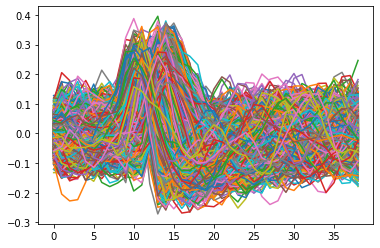

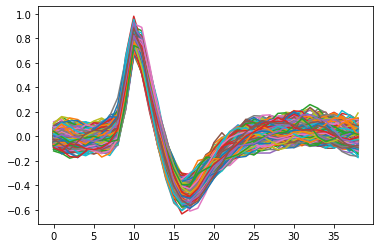

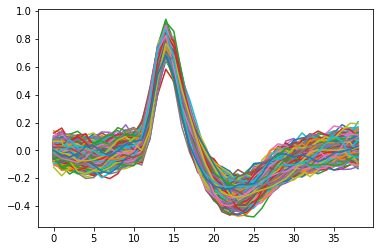

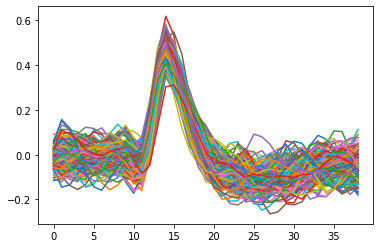

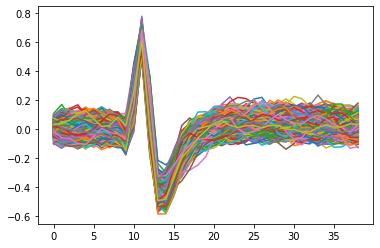

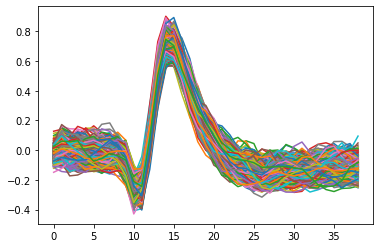

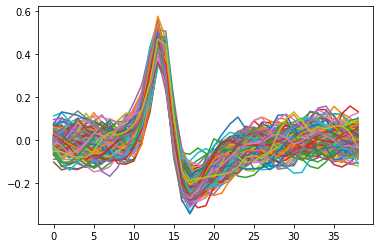

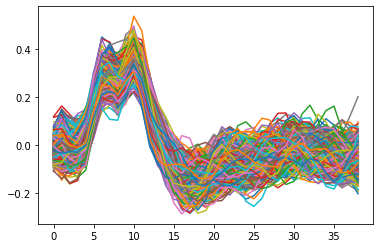

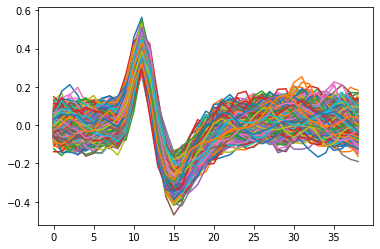

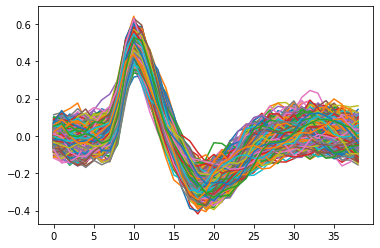

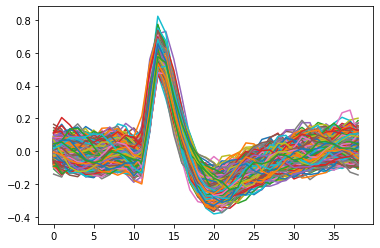

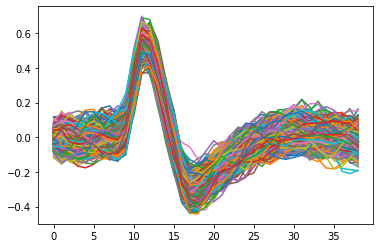

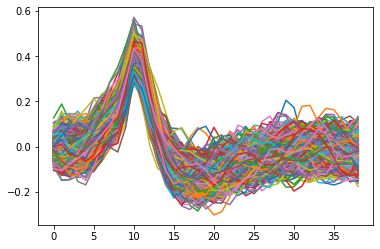

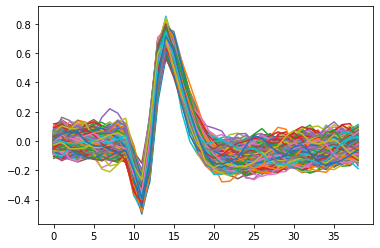

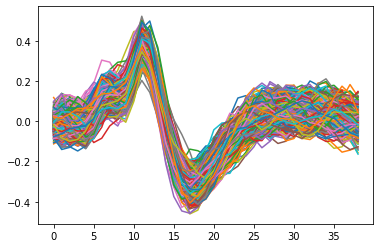

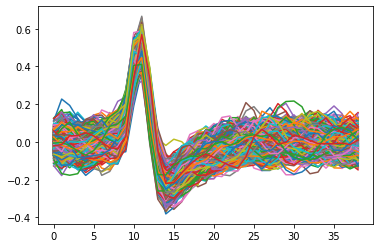

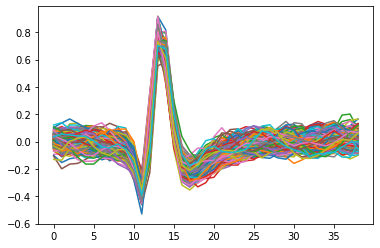

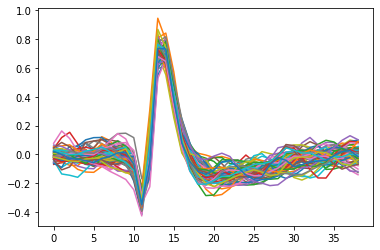

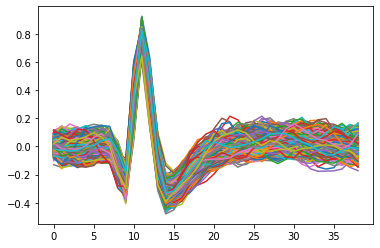

In [19]:
from scipy import signal
class SupervisedDataset(Dataset): #add SNR
    """
    Load the Pedreira data with ground truth.
    N.B. the original spike traces are downsampled from 79 to the input
    dimension of the autoencoders
    """

    def __init__(self, input_dir: str, input_dim: int = 39):
        self._input_dim = input_dim
        self._input_dir = input_dir
        folders = os.listdir(input_dir)
        self.spike_classes = np.load(
            os.path.join(input_dir, "ground_truth", "spike_classes.npy"),
            allow_pickle=True,
        ).squeeze()
        sessions = list(filter(lambda x: "session" in x, folders))
        self.sessions = sorted(sessions, key=lambda x: int(x.split("_")[1]))
        self.num_units = [np.max(sesh_spike_classes) for sesh_spike_classes in self.spike_classes]
        self.num_units = np.array(self.num_units)

    def __len__(self):
        return len(self.sessions)

    def __getitem__(self, idx: int):
        session_dir = os.path.join(self._input_dir, self.sessions[idx])
        channel_dir = os.path.join(session_dir, "channel_0")

        spikes = np.load(
            os.path.join(channel_dir, "spikes.npy"), allow_pickle=True
        ).squeeze()
        spikes = np.array([signal.resample(spike, self._input_dim) for spike in spikes])
        snrs = np.load(os.path.join(session_dir, "snrs.npy"), allow_pickle=True)
        targets = self.spike_classes[idx].squeeze()
        num_units = self.num_units[idx]
        return spikes, targets, snrs, num_units

sup_data = SupervisedDataset(data_dir)
test_idx = []
for i in range(2, 21):
    test_idx.append(list(sup_data.num_units).index(i))
train_idx = np.arange(len(sup_data))
not_test_mask = np.logical_not(np.isin(train_idx, test_idx))
train_idx = train_idx[not_test_mask]

print(len(train_idx))
print(len(test_idx))
train_data = torch.utils.data.Subset(sup_data, train_idx)
test_data = torch.utils.data.Subset(sup_data, test_idx)

spikes, targets, snrs, num_units = train_data[0]
assert len(spikes) == len(targets)
assert num_units == np.max(targets)
print("snrs=", snrs)
for target in range(np.max(targets)): 
  plt.figure()
  plt.plot(np.transpose(spikes[targets==target]))

In [20]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

ae = AEEnsemble(
    optim=torch.optim.Adam,
    convolutional_encoding=False, 
    batch_size=32, 
    epochs=50, 
    lr=(0.001, 0.001, 0.001),
    device=device, 
    activ=nn.ReLU
)
min_snr = 8

Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0


In [50]:
min_snr = 8
x = train_data
dataloader = DataLoader(x, batch_size=ae.batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=ae.batch_size)
loss = torch.nn.MSELoss()
loss_history = [[] for _ in range(len(ae.encoders))]
test_loss_history = [[] for _ in range(len(ae.encoders))]

for epoch in range(ae.training_epochs):
    for e, d in zip(ae.encoders, ae.decoders):
        e.train()
        d.train()
    epoch_loss = [[] for _ in range(len(ae.encoders))]
    test_epoch_loss = [[] for _ in range(len(ae.encoders))]
    print("\nEPOCH " + str(epoch + 1) + " of " + str(ae.training_epochs))
    for batch in dataloader.batch_sampler:
        map(lambda o: o.zero_grad(), ae.optimizers)
        data = []
        for idx in batch:
            spikes, targets, snrs, num_units = x[idx]
            possible_targets = np.arange(len(snrs))
            hi_fidel_targets = possible_targets[snrs>=min_snr]
            spikes = spikes[np.isin(targets, hi_fidel_targets)]
            if spikes[0].shape[0] > 1:
                data.append(torch.from_numpy(spikes).float())
        if len(data) == 0:
            continue
        spikes = torch.cat(data, dim=0)
        if "cuda" in ae.device:
            spikes = spikes.cuda(0)
        latent_vecs = [encoder(spikes) for encoder in ae.encoders]
        renconstructed = [
            decoder(latent_vecs[i]) for i, decoder in enumerate(ae.decoders)
        ]
        losses = [loss(spikes, r) for r in renconstructed]
        for i in range(len(losses)):
            epoch_loss[i] = losses[i].detach().cpu().item()
            losses[i].backward()
            ae.optimizers[i].step()
        # Eval Loop
        for e, d in zip(ae.encoders, ae.decoders):
            e.eval()
            d.eval()
        for batch in testloader.batch_sampler:
            map(lambda o: o.zero_grad(), ae.optimizers)
            data = []
            for idx in batch:
                spikes, targets, snrs, num_units = x[idx]
                possible_targets = np.arange(len(snrs))
                hi_fidel_targets = possible_targets[snrs>=min_snr]
                spikes = spikes[np.isin(targets, hi_fidel_targets)]
                if spikes[0].shape[0] > 1:
                    data.append(torch.from_numpy(spikes).float())
            if len(data) == 0:
                continue
            spikes = torch.cat(data, dim=0)
            if "cuda" in ae.device:
                spikes = spikes.cuda(0)
            latent_vecs = [encoder(spikes) for encoder in ae.encoders]
            renconstructed = [
                decoder(latent_vecs[i]) for i, decoder in enumerate(ae.decoders)
            ]
            losses = [loss(spikes, r) for r in renconstructed]
            for i in range(len(losses)):
                test_epoch_loss[i] = losses[i].detach().cpu().item()

    for i, ae_loss in enumerate(epoch_loss):
        loss_history[i].append(np.mean(ae_loss))
    for i, ae_loss in enumerate(test_epoch_loss):
        test_loss_history[i].append(np.mean(ae_loss))
    map(lambda s: s.step(), ae.schedulers)


loss_history = [np.array(ae_hist) for ae_hist in loss_history]
ae.save(prefix="benchmark_sim", on_drive=True)


EPOCH 1 of 50

EPOCH 2 of 50

EPOCH 3 of 50

EPOCH 4 of 50

EPOCH 5 of 50

EPOCH 6 of 50

EPOCH 7 of 50

EPOCH 8 of 50

EPOCH 9 of 50

EPOCH 10 of 50

EPOCH 11 of 50

EPOCH 12 of 50

EPOCH 13 of 50

EPOCH 14 of 50

EPOCH 15 of 50

EPOCH 16 of 50

EPOCH 17 of 50

EPOCH 18 of 50

EPOCH 19 of 50

EPOCH 20 of 50

EPOCH 21 of 50

EPOCH 22 of 50

EPOCH 23 of 50

EPOCH 24 of 50

EPOCH 25 of 50

EPOCH 26 of 50

EPOCH 27 of 50

EPOCH 28 of 50

EPOCH 29 of 50

EPOCH 30 of 50

EPOCH 31 of 50

EPOCH 32 of 50

EPOCH 33 of 50

EPOCH 34 of 50

EPOCH 35 of 50

EPOCH 36 of 50

EPOCH 37 of 50

EPOCH 38 of 50


KeyboardInterrupt: ignored

In [27]:
ae.load(prefix="benchmark_sim", on_drive=True)
train_data = torch.utils.data.Subset(sup_data, train_idx)
test_data = torch.utils.data.Subset(sup_data, test_idx)
dataloader = DataLoader(train_data, batch_size=ae.batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=ae.batch_size)

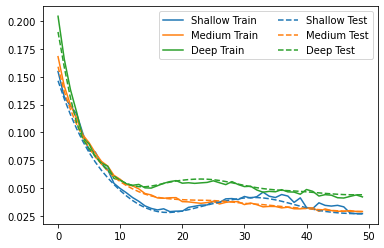

In [ ]:
plt.figure()
for i, ae_loss in enumerate(loss_history):
    plt.plot(ae_loss, c="C"+str(i))
for i, ae_loss in enumerate(test_loss_history):
    plt.plot(ae_loss, c="C"+str(i), ls="--")

plt.legend(["Shallow Train", "Medium Train", "Deep Train", "Shallow Test", "Medium Test", "Deep Test"], ncol=2)

In [28]:
for e, d in zip(ae.encoders, ae.decoders):
    e.eval()
    d.eval()
latent_vecs = []
test_targets = []
for spikes, targets, snrs, num_units in test_data:
    session_latent = []
    possible_targets = np.arange(len(snrs))
    hi_fidel_targets = possible_targets[snrs>=min_snr]
    spikes = torch.FloatTensor(spikes[np.isin(targets, hi_fidel_targets)])
    session_targets = targets[np.isin(targets, hi_fidel_targets)]
    if "cuda" in ae.device:
        spikes = spikes.cuda(0)
    for encoder in ae.encoders:
        session_latent.append(encoder(spikes))
    session_latent = torch.cat(session_latent, dim=1).detach().cpu()
    latent_vecs.append(session_latent)
    test_targets.append(session_targets)

print(len(latent_vecs))
print(latent_vecs[0].shape)
print(len(test_targets))
print(test_targets[0].shape)

19
torch.Size([457, 9])
19
(457,)


In [24]:
!pip install graspologic
from graspologic.utils import remap_labels
from graspologic.cluster.autogmm import AutoGMMCluster

     |████████████████████████████████| 5.1MB 11.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 24.2MB 128kB/s 
     |████████████████████████████████| 942kB 40.0MB/s 
     |████████████████████████████████| 440kB 36.5MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 1.2MB 38.1MB/s 
  Created wheel for graspologic: filename=graspologic-0.1.0-cp37-none-any.whl size=5147502 sha256=6464cba4f916c8d05f072878fd8767cadc2315e9e16fa9b3934952f39531ab24
  Stored in directory: /root/.cache/pip/wheels/8b/93/4f/7e45490d6f3cb0d3c7e6d709f469a55200646ee3da01ba4150
Successfully built graspologic
  Created wheel for hyppo: filename=hyppo-0.1.3-cp37-none-any.whl size=64218 sha256=75f7a9a87a01ec9a3ce1a4044f327e6d3e2d9e129ef4454c8d2a1d08ff

In [46]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
sns.set_theme()
sns.set_context("paper")

test_acc = []
test_prec = []
test_recall = []
session_weights = []
remapped_preds = []
for (i, latent), targets in zip(enumerate(latent_vecs), test_targets):
    session_weights.append(len(targets))
    units = set(targets)
    num_units = len(units)
    gmm = GaussianMixture(n_components=num_units)
    pred = gmm.fit_predict(latent)
    remapped_pred = remap_labels(targets, pred)
    remapped_preds.append(remapped_pred)
    prec = []
    recall = []
    for unit in units:
        TP = np.sum(np.logical_and(remapped_pred==unit, targets==unit))
        FP = np.sum(np.logical_and(remapped_pred==unit, targets!=unit))
        if FP == 0:
            prec.append(1)
        else:
            prec.append(TP / (TP + FP))
        TN = np.sum(np.logical_and(remapped_pred!=unit, targets!=unit))
        FN = np.sum(np.logical_and(remapped_pred!=unit, targets==unit))
        if FN == 0:
            recall.append(1)
        else:
            recall.append(TP / (TP + FN))

    test_prec.append(np.mean(prec))
    test_recall.append(np.mean(recall))
    test_acc.append(sum(remapped_pred==targets)/len(targets))

session_weights = np.array(session_weights) / sum(session_weights)
avg_acc = np.sum(test_acc*session_weights)
avg_prec = np.mean(test_acc)
avg_recall = np.mean(test_recall)

Average Accuracy= 0.7864013431589045
Average Precision= 0.8160911057700146
Average Recall= 0.7830560365804097


Text(0.5, 1.0, 'GT GMM')

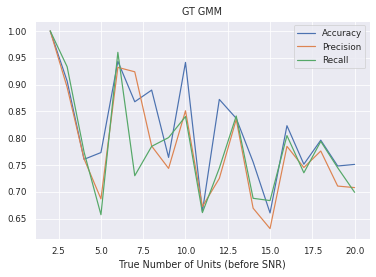

In [48]:
print("Average Accuracy=", avg_acc)
print("Average Precision=", avg_prec)
print("Average Recall=", avg_recall)

plt.figure()
plt.hold = True
plt.plot(np.arange(2, 21), test_acc, label="Accuracy")
plt.plot(np.arange(2, 21), test_prec, label="Precision")
plt.plot(np.arange(2, 21), test_recall, label="Recall")
plt.hold = False
plt.legend()
plt.xlabel("True Number of Units (before SNR)")
plt.title("GT GMM")

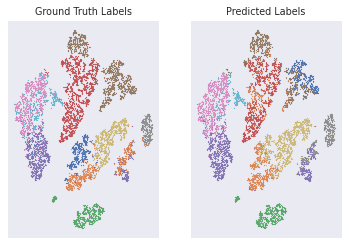

In [ ]:
for i in [0, 8, 18]
latent = latent_vecs[i]
targets = test_targets[i]
remapped_pred = remapped_preds[i]

# Plot tsne
latent_manifold = tsne.fit_transform(latent.cpu())

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
ax1.set_title("Ground Truth Labels")
ax1.set_xticks([])
ax1.set_yticks([])
for c in range(np.max(targets)+1):
    c_manifold = latent_manifold[targets == c]
    ax1.scatter(c_manifold[:, 0], c_manifold[:, 1], marker=".", s=.5)

ax2.set_title("Predicted Labels")
for c in range(np.max(remapped_pred)+1):
    c_manifold = latent_manifold[remapped_pred == c]
    ax2.scatter(c_manifold[:, 0], c_manifold[:, 1], marker=".", s=.5)

Attempting AutoGMM

In [41]:
test_acc = []
test_prec = []
test_recall = []
session_weights = []
remapped_preds = []
max_n_comps = 21
for (i, latent), targets in zip(enumerate(latent_vecs), test_targets):
    session_weights.append(len(targets))
    units = set(targets)
    num_units = len(units)
    bics = []
    preds = []
    for n_comps in range(1, max_n_comps+1):
        gmm = GaussianMixture(n_components=n_comps)
        preds.append(gmm.fit_predict(latent))
        bics.append(gmm.bic(latent))
    pred = preds[np.argmin(bics)]
    print("predicted num_units=", np.argmin(bics)+1)
    print("true num_units=", num_units)
    remapped_pred = remap_labels(targets, pred)
    remapped_preds.append(remapped_pred)
    prec = []
    recall = []
    for unit in units:
        TP = np.sum(np.logical_and(remapped_pred==unit, targets==unit))
        FP = np.sum(np.logical_and(remapped_pred==unit, targets!=unit))
        if FP == 0:
            prec.append(1)
        else:
            prec.append(TP / (TP + FP))
        TN = np.sum(np.logical_and(remapped_pred!=unit, targets!=unit))
        FN = np.sum(np.logical_and(remapped_pred!=unit, targets==unit))
        if FN == 0:
            recall.append(1)
        else:
            recall.append(TP / (TP + FN))

    test_prec.append(np.mean(prec))
    test_recall.append(np.mean(recall))
    test_acc.append(sum(remapped_pred==targets)/len(targets))

session_weights = np.array(session_weights) / sum(session_weights)
avg_acc = np.sum(test_acc*session_weights)
avg_prec = np.mean(test_acc)
avg_recall = np.mean(test_recall)

predicted num_units= 5
true num_units= 2
predicted num_units= 7
true num_units= 3
predicted num_units= 11
true num_units= 4
predicted num_units= 19
true num_units= 5
predicted num_units= 20
true num_units= 6
predicted num_units= 20
true num_units= 6
predicted num_units= 20
true num_units= 8
predicted num_units= 20
true num_units= 9
predicted num_units= 18
true num_units= 9
predicted num_units= 21
true num_units= 11
predicted num_units= 20
true num_units= 11
predicted num_units= 21
true num_units= 11
predicted num_units= 21
true num_units= 14
predicted num_units= 20
true num_units= 14
predicted num_units= 21
true num_units= 16
predicted num_units= 21
true num_units= 17
predicted num_units= 21
true num_units= 16
predicted num_units= 21
true num_units= 18
predicted num_units= 21
true num_units= 20


Average Accuracy= 0.631772655468162
Average Precision= 0.5923510564735096
Average Recall= 0.614667661621934


Text(0.5, 1.0, 'AutoGMM')

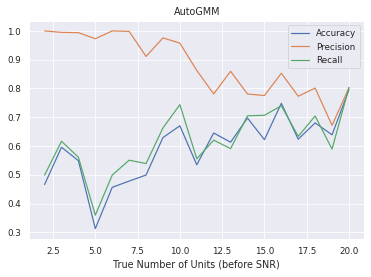

In [45]:
print("Average Accuracy=", avg_acc)
print("Average Precision=", avg_prec)
print("Average Recall=", avg_recall)

plt.figure()
plt.hold = True
plt.plot(np.arange(2, 21), test_acc, label="Accuracy")
plt.plot(np.arange(2, 21), test_prec, label="Precision")
plt.plot(np.arange(2, 21), test_recall, label="Recall")
plt.hold = False
plt.legend()
plt.xlabel("True Number of Units (before SNR)")
plt.title("AutoGMM")

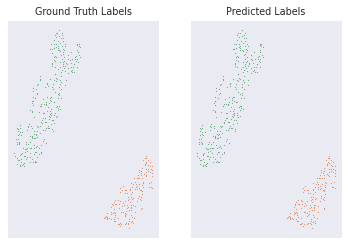

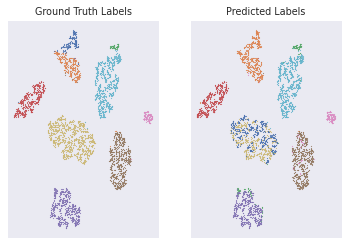

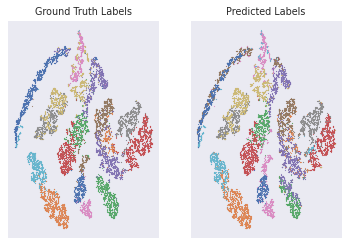

In [31]:
for i in [0, 8, 18]:
    latent = latent_vecs[i]
    targets = test_targets[i]
    remapped_pred = remapped_preds[i]

    # Plot tsne
    latent_manifold = tsne.fit_transform(latent.cpu())

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
    ax1.set_title("Ground Truth Labels")
    ax1.set_xticks([])
    ax1.set_yticks([])
    for c in range(np.max(targets)+1):
        c_manifold = latent_manifold[targets == c]
        ax1.scatter(c_manifold[:, 0], c_manifold[:, 1], marker=".", s=.5)

    ax2.set_title("Predicted Labels")
    for c in range(np.max(remapped_pred)+1):
        c_manifold = latent_manifold[remapped_pred == c]
        ax2.scatter(c_manifold[:, 0], c_manifold[:, 1], marker=".", s=.5)